## K-Means Clustering

### Setup

In [1]:
# Print software version and environment variables
import sys, os

In [2]:
# Create entry point to spark

import pyspark
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName("Spark Clustering") \
    .getOrCreate()

print (spark.version)

2.3.2


In [3]:
# Load libraries
from pyspark.context import SparkContext
from pyspark.sql import SQLContext, SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

### Read in data

In [44]:
# Load minute weather data
# spark = SparkSession.builder.master("local").appName("Word Count").getOrCreate()

# sc = SparkContext.getOrCreate()
# sqlContext = SQLContext(sc)

inputfile = "clustering_norm2.csv"
df = spark.read.load (inputfile, format="csv", inferSchema="true", header="true")
df_boleto = df.filter(df["boleto2"]>0)

In [45]:
df_boleto.show(2)

+--------------------+------------+-----------+-------+--------+--------+------+----+---------+------------+----------------+------+
|  customer_unique_id|credit_card2|debit_card2|boleto2|voucher2|monetary|nItems|freq|mon_order|nItems_order|avg_installments|sscore|
+--------------------+------------+-----------+-------+--------+--------+------+----+---------+------------+----------------+------+
|00050ab1314c0e55a...|           0|          0|      1|       0|   35.38|     1|   1|    35.38|         1.0|             1.0|   4.0|
|000949456b182f53c...|           0|          0|      1|       0|   82.05|     1|   1|    82.05|         1.0|             1.0|   4.0|
+--------------------+------------+-----------+-------+--------+--------+------+----+---------+------------+----------------+------+
only showing top 2 rows



In [46]:
colNames = ['customer_unique_id','monetary','nItems','freq','sscore','mon_order','nItems_order']
df_boleto=df_boleto[colNames]

In [47]:
df_boleto.count()

9866

### Explore data

In [48]:
# Create feature vector
ignore = ['customer_unique_id']
featuresVec = [x for x in df_boleto.columns if x not in ignore]
featuresVec



['monetary', 'nItems', 'freq', 'sscore', 'mon_order', 'nItems_order']

In [49]:
# Create feature vector
assembler = VectorAssembler(
    inputCols=[x for x in df_boleto.columns if x not in ignore],
    outputCol='aux')
assembled = assembler.transform(df_boleto)

In [50]:
# Scale data
scaler = StandardScaler(inputCol="aux", outputCol="features", withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)

In [51]:
scaledData.show(5)

+--------------------+--------+------+----+------+---------+------------+--------------------+--------------------+
|  customer_unique_id|monetary|nItems|freq|sscore|mon_order|nItems_order|                 aux|            features|
+--------------------+--------+------+----+------+---------+------------+--------------------+--------------------+
|00050ab1314c0e55a...|   35.38|     1|   1|   4.0|    35.38|         1.0|[35.38,1.0,1.0,4....|[-0.2156152152957...|
|000949456b182f53c...|   82.05|     1|   1|   4.0|    82.05|         1.0|[82.05,1.0,1.0,4....|[-0.1590830174691...|
|000ec5bff359e1c0a...|   27.75|     1|   1|   5.0|    27.75|         1.0|[27.75,1.0,1.0,5....|[-0.2248575694722...|
|000fbf0473c10fc1a...| 1449.52|    10|   4|   5.0|   362.38|         2.5|[1449.52,10.0,4.0...|[1.49735762024254...|
|00196c4c9a3af7dd2...|   37.58|     1|   1|   5.0|    37.58|         1.0|[37.58,1.0,1.0,5....|[-0.2129503163195...|
+--------------------+--------+------+----+------+---------+------------

### Apply k-means clustering

In [52]:
scaledData = scaledData.select("features", "customer_unique_id")

elbowset = scaledData.select("features")
elbowset.persist()
elbowset.count()

9866

In [53]:
# Generate clusters for elbow plot

clusters = range(2,20)
wsseList = utils.elbow(elbowset, clusters)

Training for cluster size 2 
......................WSSE = 11081.980958137317 
Training for cluster size 3 
......................WSSE = 10962.917575605848 
Training for cluster size 4 
......................WSSE = 9296.12663478216 
Training for cluster size 5 
......................WSSE = 10516.96137780337 
Training for cluster size 6 
......................WSSE = 7313.022278773834 
Training for cluster size 7 
......................WSSE = 7571.505295393996 
Training for cluster size 8 
......................WSSE = 7321.848965522093 
Training for cluster size 9 
......................WSSE = 5957.748796244194 
Training for cluster size 10 
......................WSSE = 5773.923426831117 
Training for cluster size 11 
......................WSSE = 5419.242150956265 
Training for cluster size 12 
......................WSSE = 5187.469447341636 
Training for cluster size 13 
......................WSSE = 5051.539788232698 
Training for cluster size 14 
......................WSSE = 5057.6599372

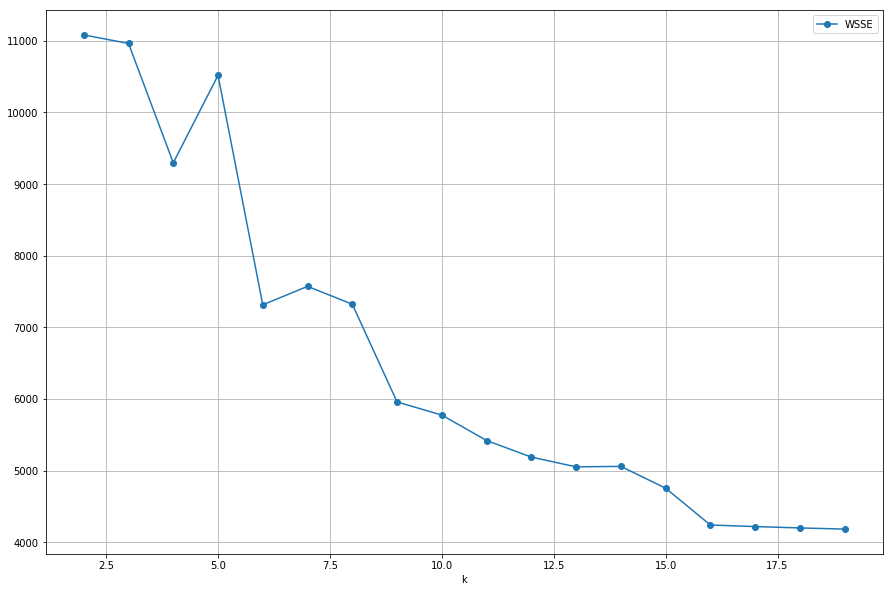

In [54]:
# Show elbow plot


utils.elbow_plot(wsseList, clusters)

In [55]:
# Run KMeans for k = 6

scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

kmeans = KMeans(k=6, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

#### Compute cluster centers

In [56]:
centers = model.clusterCenters()
P = utils.pd_centers(featuresVec, centers)
centers

[array([-0.11968233, -0.14867048, -0.2516099 ,  0.47342176, -0.14232204,
        -0.25860684]),
 array([ 2.60458093,  4.29147471,  5.61138517, -0.66908634,  1.40943968,
         5.69343584]),
 array([26.79107061, 20.61452378, 12.56282967, -1.16056917, 12.30518467,
        14.4563743 ]),
 array([0.28271512, 0.6307357 , 1.51152891, 0.03927788, 0.23048524,
        1.49581919]),
 array([-0.09202286, -0.10574619, -0.15736075, -1.71279338, -0.09521687,
        -0.14122237]),
 array([ 1.53442921,  0.02724508,  0.11050438, -0.04544012,  4.82590768,
         0.14191127])]

In [57]:
P

,monetary,nItems,freq,sscore,mon_order,nItems_order,prediction
0,-0.119682,-0.148670,-0.251610,0.473422,-0.142322,-0.258607,0
1,2.604581,4.291475,5.611385,-0.669086,1.409440,5.693436,1
2,26.791071,20.614524,12.562830,-1.160569,12.305185,14.456374,2
3,0.282715,0.630736,1.511529,0.039278,0.230485,1.495819,3
4,-0.092023,-0.105746,-0.157361,-1.712793,-0.095217,-0.141222,4
5,1.534429,0.027245,0.110504,-0.045440,4.825908,0.141911,5


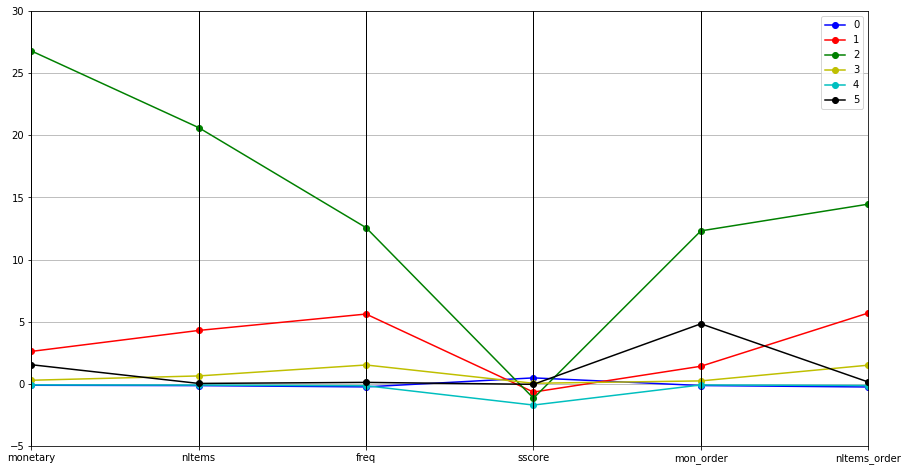

In [58]:
utils.parallel_plot(P,P,ylim=[-5,30])

### Radar Plot

#### Librarys and Variable Preparations

In [59]:
# Libraries
import matplotlib.pyplot as plt
import pandas as pd
from math import pi
import numpy as np

# number of variable
R = P.drop(columns=['prediction'])
R

,monetary,nItems,freq,sscore,mon_order,nItems_order
0,-0.119682,-0.148670,-0.251610,0.473422,-0.142322,-0.258607
1,2.604581,4.291475,5.611385,-0.669086,1.409440,5.693436
2,26.791071,20.614524,12.562830,-1.160569,12.305185,14.456374
3,0.282715,0.630736,1.511529,0.039278,0.230485,1.495819
4,-0.092023,-0.105746,-0.157361,-1.712793,-0.095217,-0.141222
5,1.534429,0.027245,0.110504,-0.045440,4.825908,0.141911


#### Single Radar Plot

In [60]:
categories=list(R)
N = len(categories)
 
# We are going to plot the first line of the data frame.
# But we need to repeat the first value to close the circular graph:
values=R.loc[0].values.flatten().tolist()
values += values[:1]
values

[-0.11968233154428584,
 -0.14867048123769205,
 -0.25160989645582227,
 0.47342175999181096,
 -0.14232204498430884,
 -0.25860683657219846,
 -0.11968233154428584]

In [61]:
# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

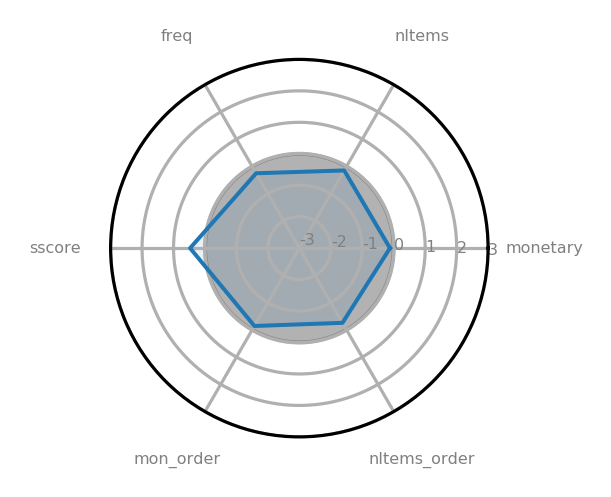

In [62]:
# Set the clarity of the figure
my_dpi=288
plt.figure(figsize=(500/my_dpi, 500/my_dpi), dpi=my_dpi)

# Initialize the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='Grey', size=4)
 
# Draw ylabels
ax.set_rlabel_position(-3)
plt.yticks([-3,-2,-1,0,1,2,3], ["-3","-2","-1","0","1","2","3"], color="grey", size=4)
plt.ylim(-3,3)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')

thetas = np.linspace(0,2*np.pi,100)
ax.fill(thetas, [0 for i in thetas], color = "black", alpha = 0.3)
 
# Fill area
ax.fill(angles, values, 'd', alpha=0.1)

ax.set_facecolor('white')

#### Plot with Multiple Series

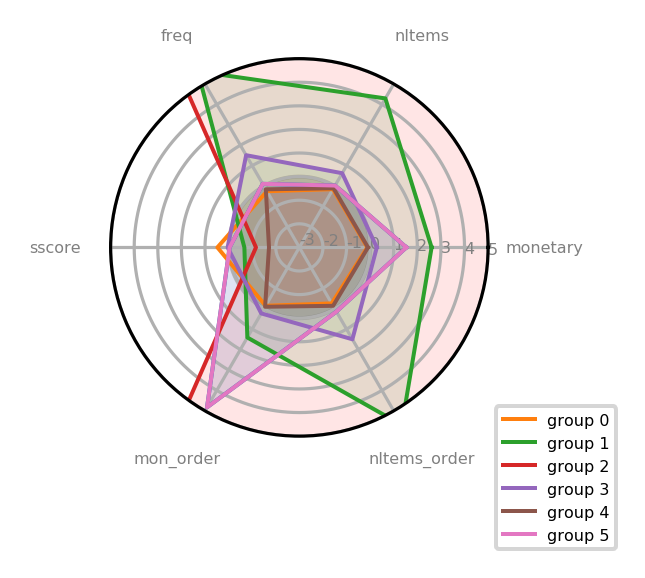

In [65]:
# Set the clarity of the figure
my_dpi=288
plt.figure(figsize=(500/my_dpi, 500/my_dpi), dpi=my_dpi)

# Initialize the spider plot
ax = plt.subplot(111, polar=True)
 
# Draw one axe per variable + add labels labels yet
plt.xticks(angles[:-1], categories, color='Grey', size=4)
 
# Draw ylabels
ax.set_rlabel_position(-3)
plt.yticks([-3,-2,-1,0,1,2,3,4,5], ["-3","-2","-1","0","1","2","3","4","5"], color="grey", size=4)
plt.ylim(-3,5)
 
# Plot data
ax.plot(angles, values, linewidth=1, linestyle='solid')

thetas = np.linspace(0,2*np.pi,100)
ax.fill(thetas, [0 for i in thetas], color = "#757575", alpha = 0.3)
 
# Fill area
ax.fill(angles, values, 'd', alpha=0.1)
    
# Ind1
values=R.loc[0].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 0")
ax.fill(angles, values, 'o', alpha=0.1)
 
# Ind2
values=R.loc[1].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 1")
ax.fill(angles, values, 'g', alpha=0.1)

# Ind3

values=R.loc[2].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 2")
ax.fill(angles, values, 'r', alpha=0.1)

# Ind 4

values=R.loc[3].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 3")
ax.fill(angles, values, 'p', alpha=0.1)

# Ind 5

values=R.loc[4].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 4")
ax.fill(angles, values, 'p', alpha=0.1)

# Ind 6

values=R.loc[5].values.flatten().tolist()
values += values[:1]
ax.plot(angles, values, linewidth=1, linestyle='solid', label="group 5")
ax.fill(angles, values, 'p', alpha=0.1)


# Add legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.1), prop={'size': 4})


#### Facet Plot

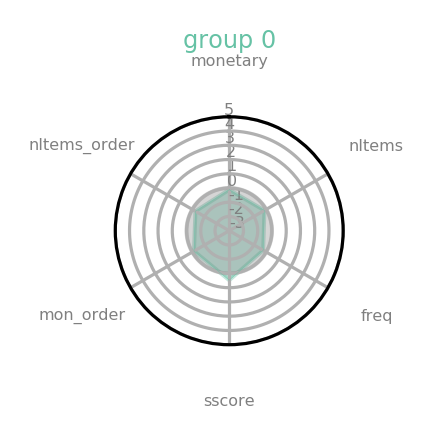

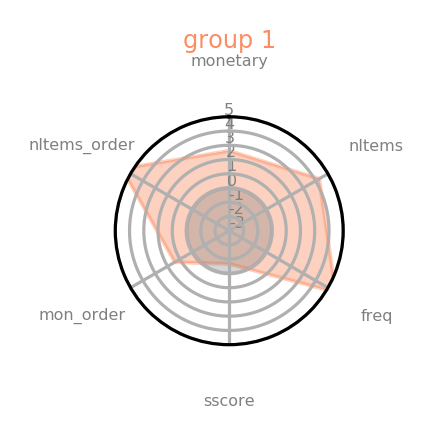

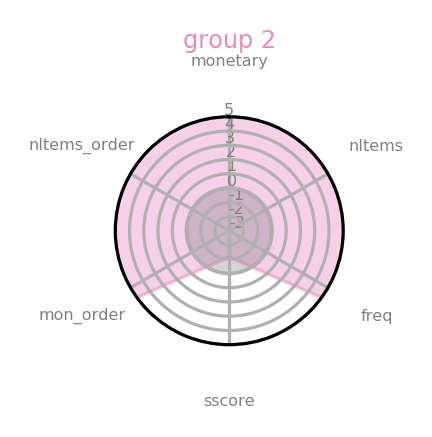

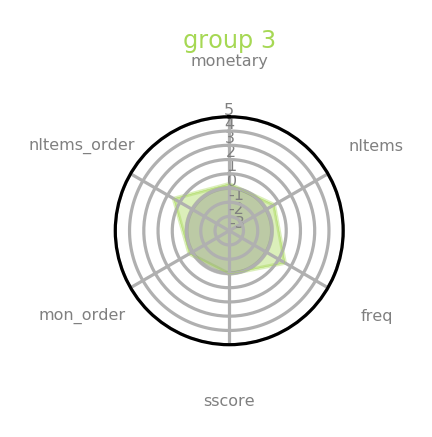

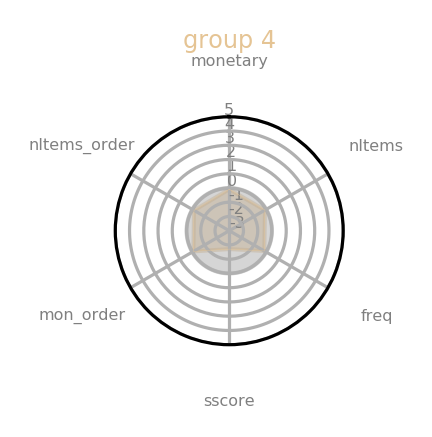

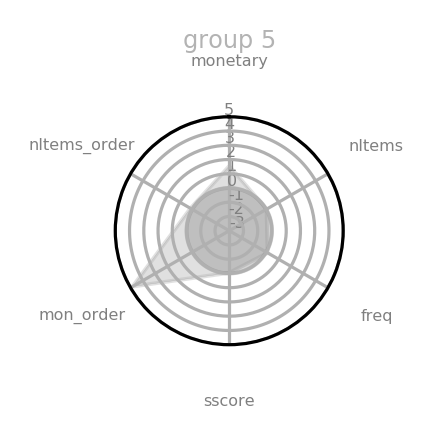

In [67]:
# ------- PART 1: Define a function that do a plot for one line of the dataset!
 
def make_spider(row, title, color):

    # Set the clarity of the figure
    my_dpi=288
    plt.figure(figsize=(1000/my_dpi, 1000/my_dpi), dpi=my_dpi)
    
    # number of variable
    categories=list(R)
    N = len(categories)
 
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
 
    # Initialise the spider plot
    ax = plt.subplot(2,3,row+1, polar=True, )
 
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
 
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=4)
 
    # Draw ylabels
    ax.set_rlabel_position(-3)
    plt.yticks([-3,-2,-1,0,1,2,3,4,5], ["-3","-2","-1","0","1","2","3","4","5"], color="grey", size=4)
    plt.ylim(-3,5)
 
    # Ind1
    values=R.loc[row].values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=0.1, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)
    
    # Shade below-mean parts
    thetas = np.linspace(0,2*np.pi,100)
    ax.fill(thetas, [0 for i in thetas], color = "#757575", alpha = 0.3)
 
    # Add a title
    plt.title(title, size=6, color=color, y=1.2)

# ------- PART 2: Apply to all individuals
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set2", len(R.index))
 
# Loop to plot
for row in range(0, len(R.index)):
    make_spider(row=row, title='group '+str(row), color=my_palette(row))


In [69]:
rows = transformed.collect()

c0 = 0
c1 = 0
c2 = 0
c3 = 0
c4 = 0
c5 = 0

for customer in rows:
    if customer.prediction == 0:
        c0 += 1
    if customer.prediction == 1:
        c1 += 1
    if customer.prediction == 2:
        c2 += 1
    if customer.prediction == 3:
        c3 += 1
    if customer.prediction == 4:
        c4 += 1
    if customer.prediction == 5:
        c5 += 1

print(c0, c1, c2, c3, c4, c5 , df.count(), c0+c1+c2+c3+c4+c5)

6928 132 8 781 1872 145 51787 9866


In [25]:
spark.stop()